In [1]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
import lal,sys
from tqdm import tqdm
from scipy import interpolate
import numpy
from pycbc import conversions as con
from pycbc import waveform

In [2]:
def deltamass_localrate(m,f):
    '''
    m is mass
    f is fraction of PBH in dark matter
    '''
    sigma_eq = 0.005
    return 3e6*f**2*(0.7*f**2+sigma_eq**2)**(-21./74)*m**(-32/37)

In [3]:
deltamass_localrate(30,3e-3)

27.048610592358646

# Model Independent Rate Results

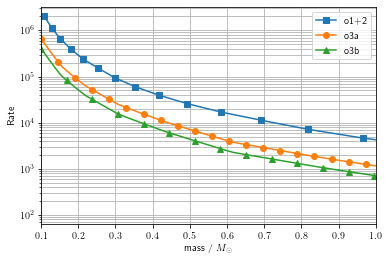

In [5]:
o3a = np.loadtxt('./noneccO3a.txt')
o3b = np.loadtxt('./noneccO3b.txt')
o2 = np.loadtxt('./noneccO2.txt')
plt.plot(con.mass1_from_mchirp_q(o2[:,0],1),o2[:,1],marker='s',label='o1+2')
plt.plot(con.mass1_from_mchirp_q(o3a[:,0],1),o3a[:,1],marker='o',markevery=4,label='o3a')
plt.plot(con.mass1_from_mchirp_q(o3b[:,0],1),o3b[:,1],marker='^',markevery=4,label='o3b')
plt.yscale('log')
plt.xlim(0.1,1)
plt.xlabel('mass / $M_\odot$')
plt.ylabel('Rate')
plt.legend()

# Constraint to fraction of PBH

In [6]:
res_o2 = []
res_o3a = []
res_o3b = []
o2mass = con.mass1_from_mchirp_q(o2[:,0],1)
o3amass = con.mass1_from_mchirp_q(o3a[:,0],1)
o3bmass = con.mass1_from_mchirp_q(o3b[:,0],1)

def get_constraint(mass,rate):
    result = []
    for i,_ in enumerate(mass):
        def CacheFunction(f):
            return deltamass_localrate(mass[i],f) - rate[i]
        sol = optimize.root_scalar(CacheFunction, bracket=[1e-4, 1], method='brentq')
        result.append(sol.root)
    return(np.array(result))

In [7]:
res_o2 = get_constraint(o2mass,o2[:,2])
res_o3a = get_constraint(o3amass,o3a[:,1])
res_o3b = get_constraint(o3bmass,o3b[:,1])

Text(0.5, 1.0, 'comparable mass')

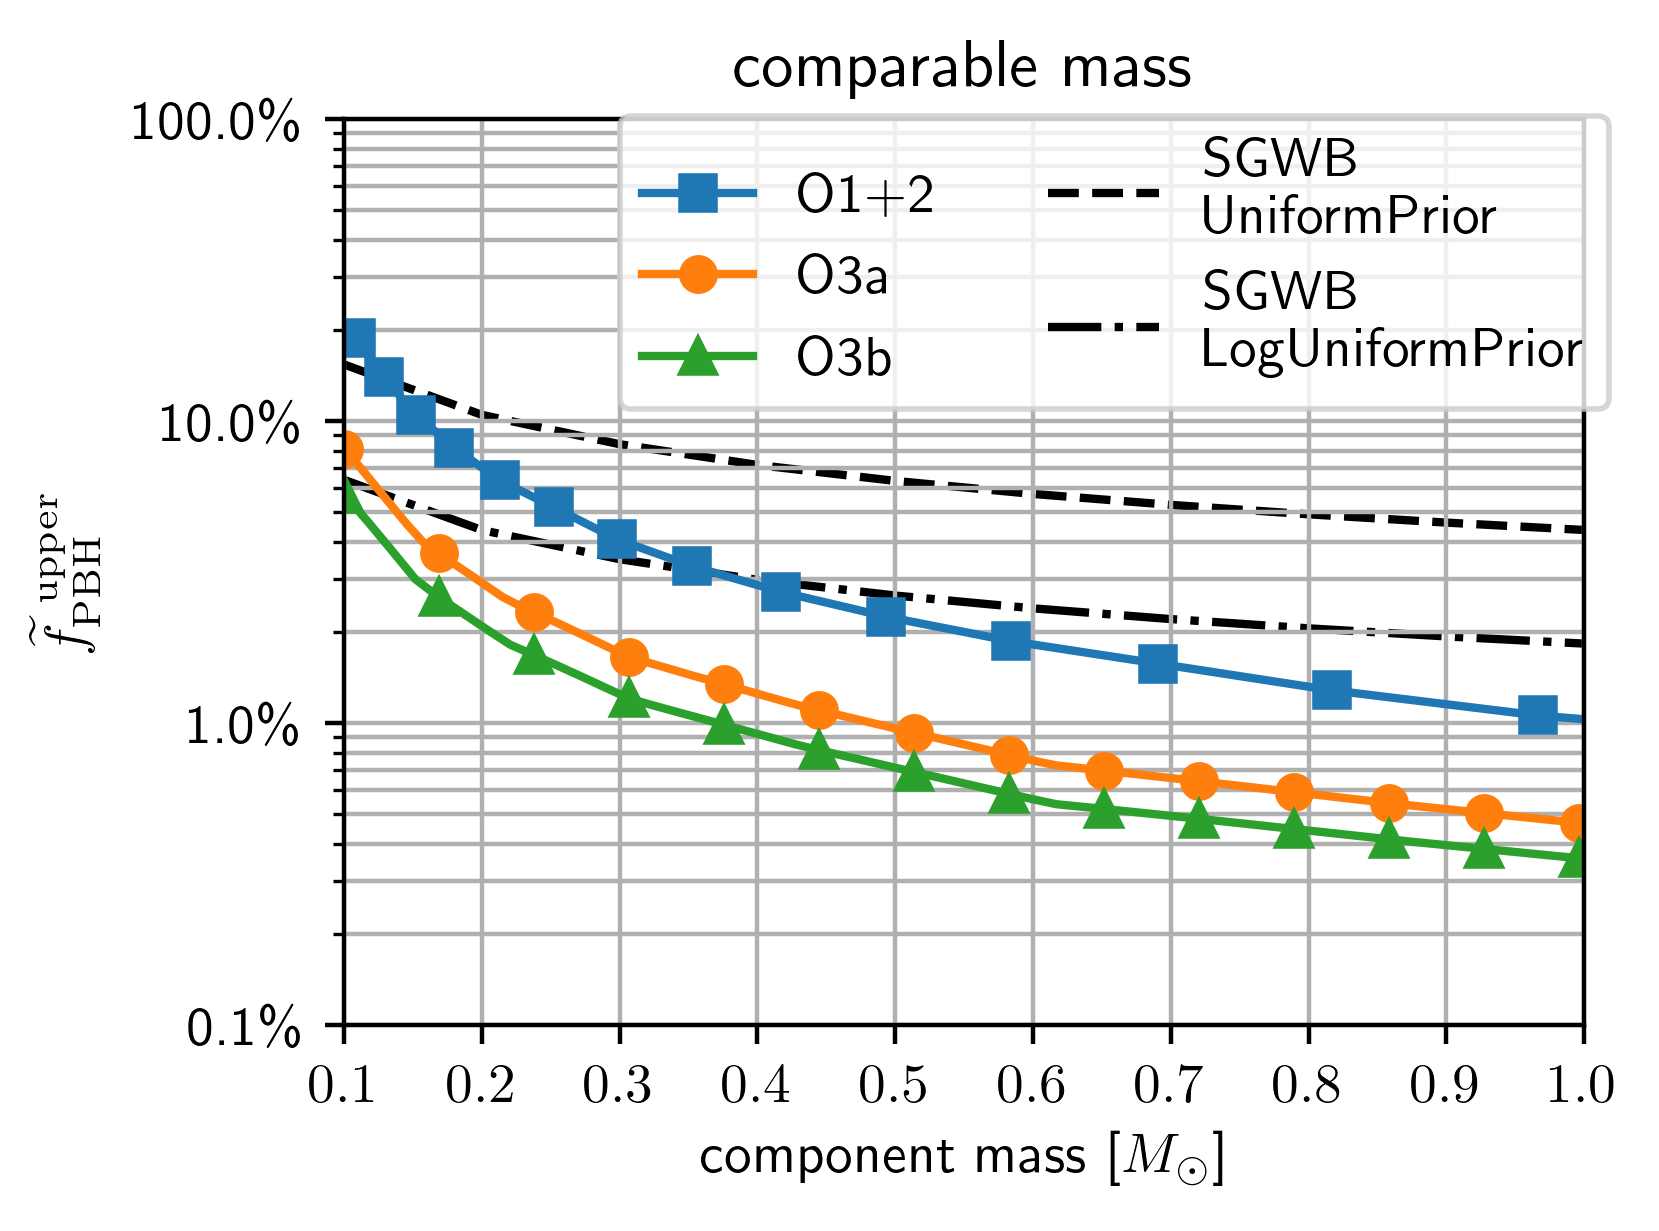

In [34]:
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter 

fig = plt.figure(figsize=[4,3], dpi=400) 
ax = fig.add_subplot(111)

ax.plot(o2mass,res_o2,marker='s',markevery=1,label='O1+2')
ax.plot(o3amass,res_o3a,marker='o',markevery=6,label='O3a')
ax.plot(o3bmass,res_o3b,marker='^',markevery=4,label='O3b')
####### SGWB ########################
f = np.loadtxt('./sgwb_com_mass_uniform.txt')
f2 = np.loadtxt('./sgwb_com_mass_loguniform.txt')
ax.plot(f[:,0],f[:,1],ls='--',color='black',zorder=-1,label='SGWB \nUniformPrior')
ax.plot(f2[:,0],f2[:,1],ls='-.',color='black',zorder=-1,label='SGWB \nLogUniformPrior')

ax.set_yscale('log')
ax.set_xlim(0.1,1)
ax.set_xlabel('mass / $M_\odot$')
ax.legend()
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(1e-3,1)
ax.set_xlim(0.1,1.0)
ax.set_xticks(np.arange(0.1, 1.1, 0.1))
xticks = mtick.PercentFormatter(xmax=1,decimals=1) 
#ax.xaxis.set_major_formatter(xticks) 
ax.yaxis.set_major_formatter(xticks) 
ax.set_xlabel('component mass [$M_\odot$]')
ax.grid(True,which="both",ls='-')
ax.set_ylabel('$\widetilde{f}_\mathrm{PBH}^{~\mathrm{upper}}$')
ax.legend(ncol=2,bbox_to_anchor=(0.2, 0.65))
ax.set_title('comparable mass')
#fig.savefig('equalmass.pdf',bbox_inches='tight')

# High mass ratio

In [37]:
# m1up: [7,100]; m2up: [0.1,1]
# m1low: [20,100]; m2low: [0.01,0.04]
ratef = np.loadtxt('0104-rate_limits.txt')

m1up,m2up,rateup = ratef[:49,0],ratef[:49,1],ratef[:49,2]
m1low,m2low,ratelow = ratef[49:,0],ratef[49:,1],ratef[49:,2]

In [38]:
def spline_interp(m1,m2,rate,add_layer=None):
    
    rm1 = numpy.unique(m1)
    rm2 = numpy.unique(m2)
    rs = rate.reshape(len(rm1), len(rm2))
    
    if add_layer:
        add_interp, add_val = add_layer
        rm2 = numpy.append(rm2, add_val)
        
        nrate = [add_interp(a, add_val) for a in rm1]
        rs = numpy.vstack([rs.T, nrate]).T
        
    rs = rs.reshape(len(rm1), len(rm2))
    
    # Bivariate spline approximation over a rectangular mesh.
    # kx, ky: Degrees of the bivariate spline. Default is 3.
    iup = interpolate.RectBivariateSpline(numpy.log(rm1), numpy.log(rm2), numpy.log(rs), kx=1, ky=1)
    return lambda m1, m2: numpy.exp(iup(numpy.log(m1), numpy.log(m2))[0][0])
      
def get_rate(m1, m2):
    iup  = spline_interp(m1up,m2up,rateup)
    ilow = spline_interp(m1low,m2low,ratelow, add_layer=(iup, .1))
    #ilow: add a layer of mass2 = 0.1 to glue the interpolation between iup and ilow

    rvals = []
    for m1v, m2v in zip(m1, m2):
        if m2v >= .1:
            rvals.append(iup(m1v, m2v))
        else:
            rvals.append(ilow(m1v, m2v))
    return numpy.array(rvals)

[80. 80. 80. 80. 80. 80. 80. 80. 80.] [0.02154435 0.04641589 0.1        0.14677993 0.21544347 0.31622777
 0.46415888 0.68129207 1.        ]
[37. 37. 37. 37. 37. 37. 37. 37. 37.] [0.02154435 0.04641589 0.1        0.14677993 0.21544347 0.31622777
 0.46415888 0.68129207 1.        ]
[20. 20. 20. 20. 20. 20. 20. 20. 20.] [0.02154435 0.04641589 0.1        0.14677993 0.21544347 0.31622777
 0.46415888 0.68129207 1.        ]
[10. 10. 10. 10. 10. 10.] [0.14677993 0.21544347 0.31622777 0.46415888 0.68129207 1.        ]


Text(0, 0.5, 'Merger Rate [Gpc$^{-3}$yr$^{-1}$]')

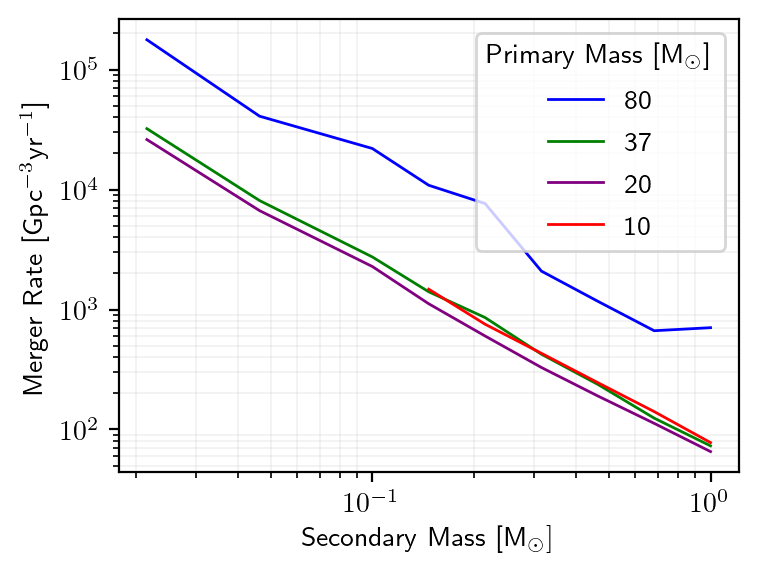

In [39]:
import pylab
pylab.figure(figsize=[4, 3], dpi=200)
pylab.rc('text', usetex=True)
#fig = plt.figure(figsize=[4,3], dpi=400) 
#ax = fig.add_subplot(111)

rm2u = numpy.unique(ratef[:,1])

for prim, c in zip([80, 37, 20, 10], ['blue', 'green', 'purple', 'red',]):
    if prim < 20.0:
        smin = .1
    else:
        smin = .01
        
    s = rm2u[rm2u > smin]
    p = numpy.ones(len(s)) * prim
    print(p,s)
    r  = get_rate(p, s)
    #pylab.fill_between(s, r-e, r+e, color=c, alpha=0.3)
    
    pylab.errorbar(s, r, label='{:.0f}'.format(prim), color=c, linewidth=1)

pylab.legend(title='Primary Mass [M$_\odot$]')
pylab.grid(which='major')
pylab.grid(which='minor', linewidth=.1)
pylab.yscale('log')
pylab.xscale('log')
pylab.xlabel('Secondary Mass [M$_\odot]$')
pylab.ylabel('Merger Rate [Gpc$^{-3}$yr$^{-1}$]')

In [40]:
def twomass_localrate(m1,m2,p_m1):
    # fix the primary mass's f_pbh to be 3e-3
    f_pbh_m1 = 3e-3
    # the fraction of p1 is a free variable
    p1 = p_m1
    p2 = 1-p1
    # the total fraction of PBH including m1 and m2
    f = f_pbh_m1/p_m1
    sigma_eq = 0.005
    return 3e6*f**2*(0.7*f**2+sigma_eq**2)**(-21./74) \
            *min(p1/m1,p2/m2)*(p1/m1+p2/m2)*(m1*m2)**(3./37)*(m1+m2)**(36./37)

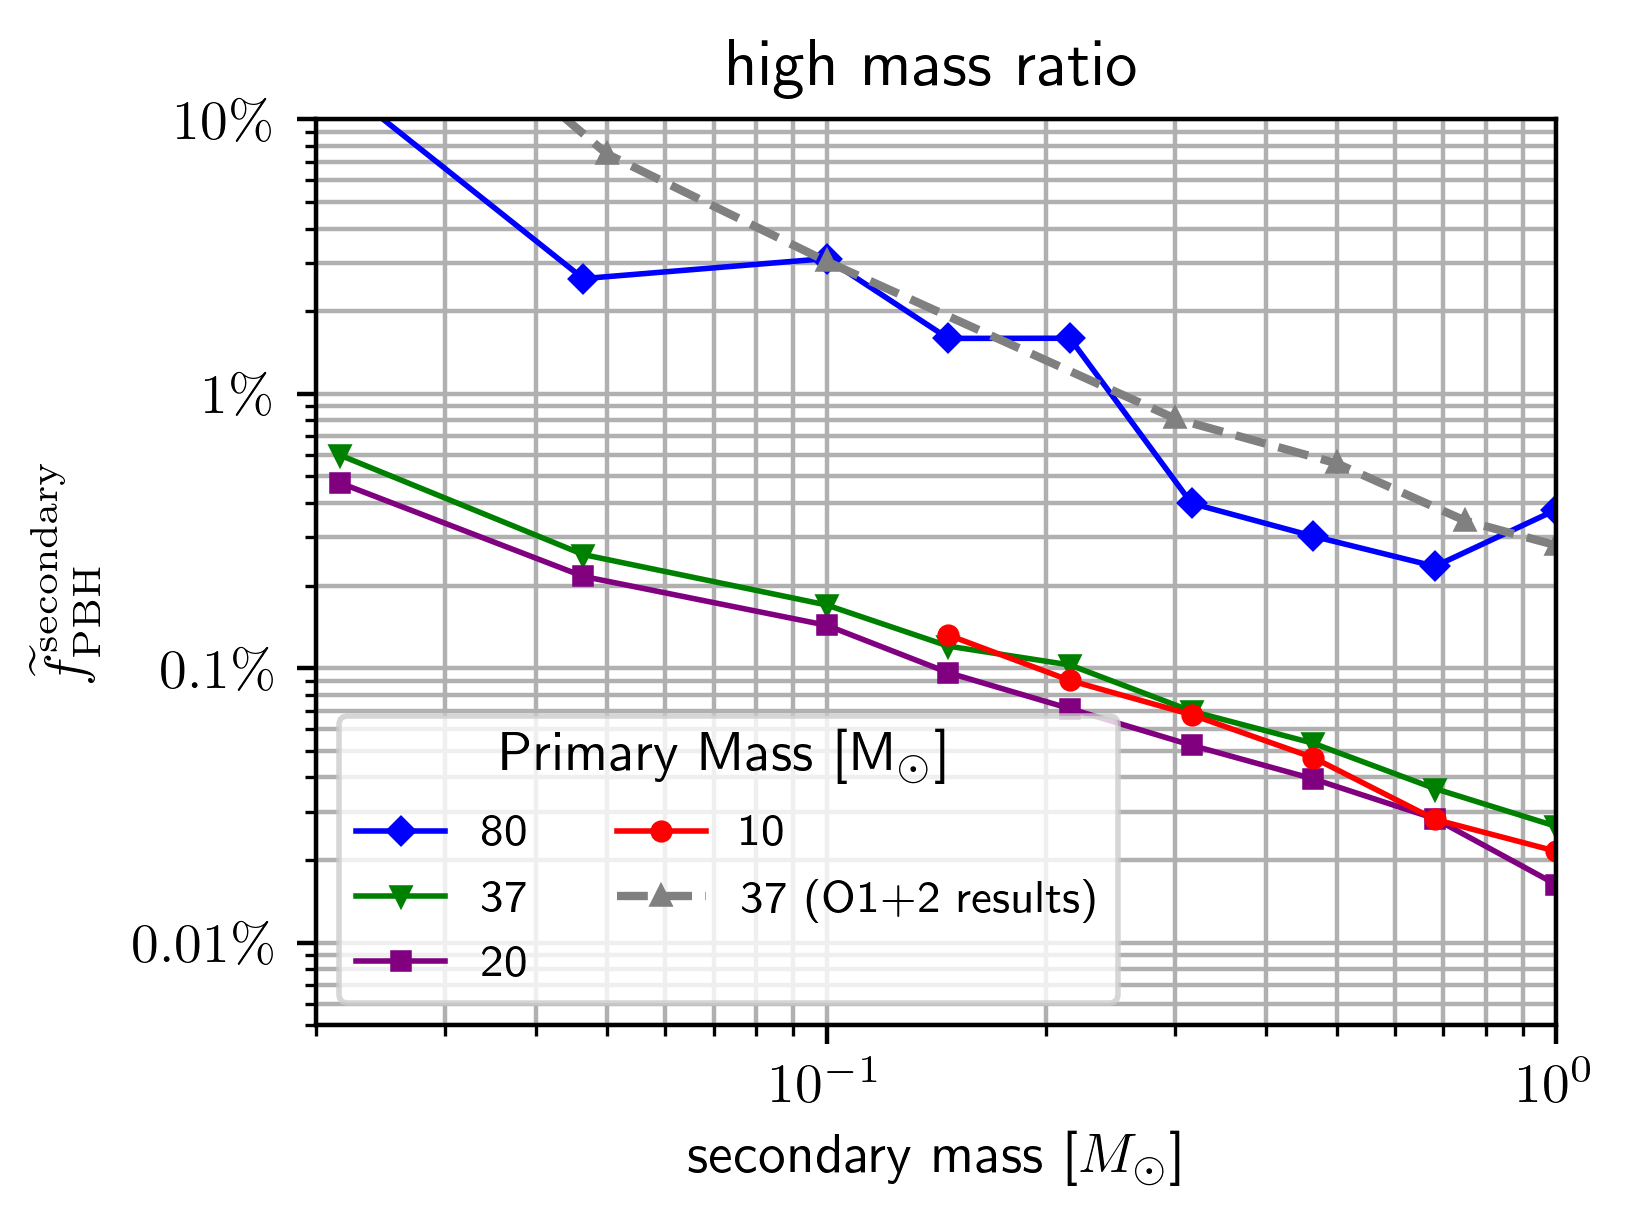

In [66]:
oldd = np.loadtxt('./oldhmrdata.txt')

mass1plot = [80,37,20,10]
p_m1_result = {}
for prim, c in zip(mass1plot, ['blue', 'green', 'purple', 'red',]):
    if prim < 20.0:
        smin = .1
    else:
        smin = .01
        
    s = rm2u[rm2u > smin]
    p = numpy.ones(len(s)) * prim
    r  = get_rate(p, s)
    p_m1_v = []
    for m2v,ratev in zip(s,r):
        def CacheFunction(p_m1):
            # The variable is p_m1
            return twomass_localrate(m1=prim,m2=m2v,p_m1=p_m1)-ratev
        sol = optimize.root_scalar(CacheFunction, bracket=[1e-5, 1], method='brentq')
        p_m1_v.append(sol.root)
    p_m1_result.update({prim:p_m1_v})
    
marker = ['D','v','s','o']
#plt.figure(figsize=[4,3], dpi=400)

fig = plt.figure(figsize=[4,3], dpi=400) 
ax = fig.add_subplot(111)

for prim, c,m in zip(mass1plot, ['blue', 'green', 'purple', 'red',],marker):
    if prim < 20.0:
        smin = .1
    else:
        smin = .01
        
    s = rm2u[rm2u > smin]
    p = numpy.ones(len(s)) * prim
    pm1 = np.array(p_m1_result[prim])
    ax.plot(s,3e-3/pm1*(1-pm1),label='{:.0f}'.format(prim), marker=m,ms=3, color=c,linewidth=1)

ax.plot(oldd[:,0],3e-3/oldd[:,1]*(1-oldd[:,1]),color='grey',marker='^',ms=3,ls='--',label='37 (O1+2 results)')
ax.legend(title='Primary Mass [M$_\odot$]',loc='lower left',ncol=2,prop={'size': 8})
#ax.grid(which='major')
#ax.grid(which='minor', linewidth=.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(5e-5,1e-1)
ax.set_xlim(2e-2,1)
plt.yticks([1e-4,0.001,0.01,0.1],[r'$0.01\%$',r'$0.1\%$',r'$1\%$',r'$10\%$'])

#xticks = mtick.PercentFormatter(xmax=1,decimals=2) 
#ax.xaxis.set_major_formatter(xticks) 
#ax.yaxis.set_major_formatter(xticks) 

ax.set_xlabel('secondary mass [$M_\odot$]')
ax.set_ylabel('$\widetilde{f}_\mathrm{PBH}^\mathrm{secondary}$')
ax.set_title('high mass ratio')
fig.savefig('hmro3b.pdf',bbox_inches='tight')

# Plot two results in the same figure

In [80]:
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

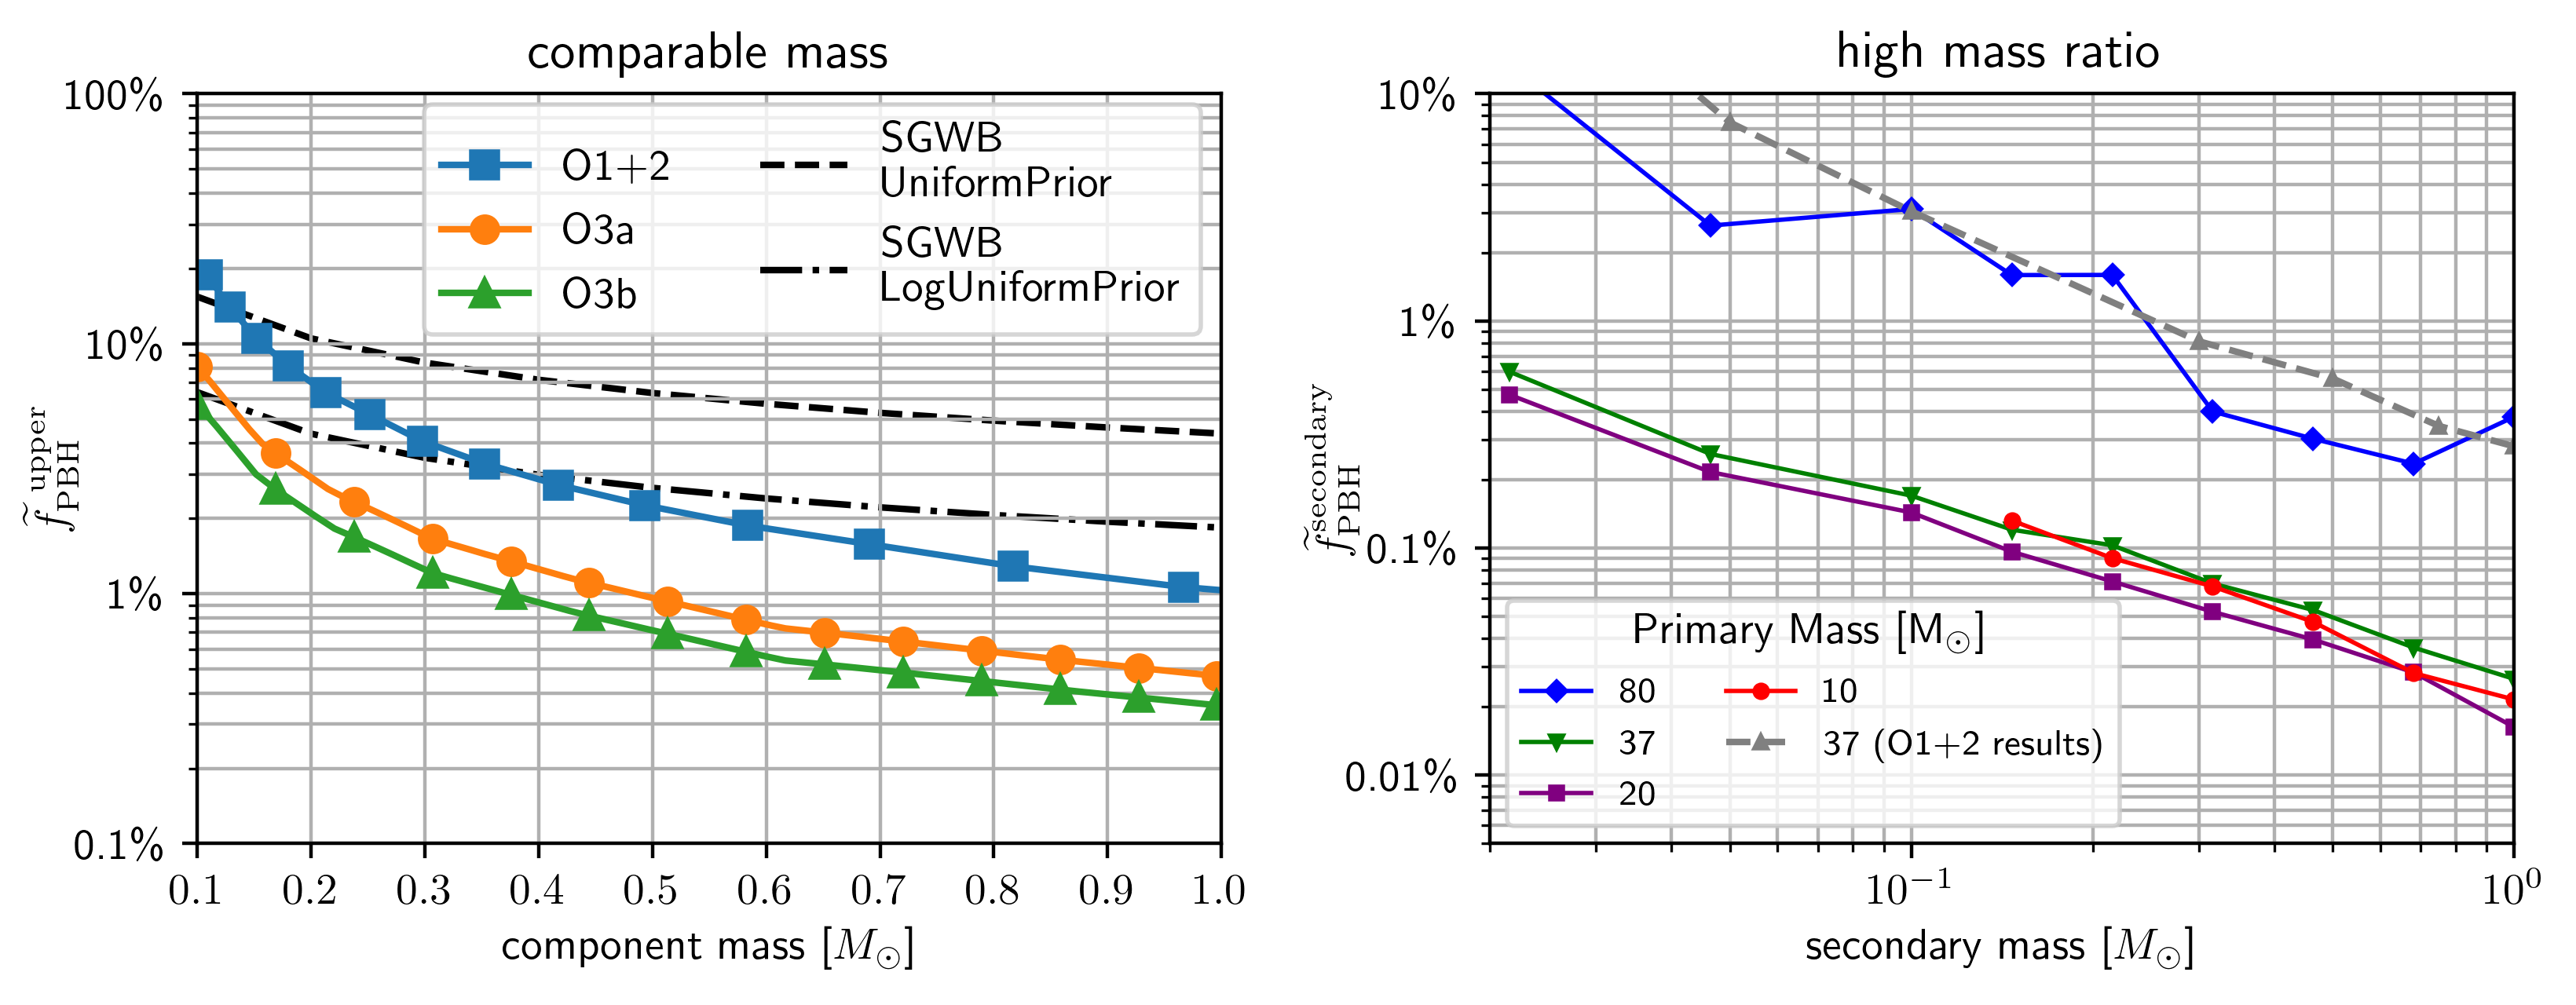

In [106]:
fig = plt.figure(figsize=[8,3],dpi=400) 
ax = fig.add_subplot(121)

ax.plot(o2mass,res_o2,marker='s',markevery=1,label='O1+2')
ax.plot(o3amass,res_o3a,marker='o',markevery=6,label='O3a')
ax.plot(o3bmass,res_o3b,marker='^',markevery=4,label='O3b')
####### SGWB ########################
f = np.loadtxt('./sgwb_com_mass_uniform.txt')
f2 = np.loadtxt('./sgwb_com_mass_loguniform.txt')
ax.plot(f[:,0],f[:,1],ls='--',color='black',zorder=-1,label='SGWB \nUniformPrior')
ax.plot(f2[:,0],f2[:,1],ls='-.',color='black',zorder=-1,label='SGWB \nLogUniformPrior')

ax.set_yscale('log')
ax.set_xlim(0.1,1)
ax.set_xlabel('mass / $M_\odot$')
ax.legend()
ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(1e-3,1)
ax.set_xlim(0.1,1.0)
ax.set_xticks(np.arange(0.1, 1.1, 0.1))
xticks = mtick.PercentFormatter(xmax=1,decimals=1) 
#ax.xaxis.set_major_formatter(xticks) 
ax.yaxis.set_major_formatter(xticks) 
ax.set_xlabel('component mass [$M_\odot$]')
ax.grid(True,which="both",ls='-')
ax.set_ylabel('$\widetilde{f}_\mathrm{PBH}^{~\mathrm{upper}}$',labelpad=-5)
ax.legend(ncol=2,bbox_to_anchor=(0.2, 0.65))
ax.set_title('comparable mass')
plt.yticks([1e-3,0.01,0.1,1],[r'0.1\%',r'1\%',r'10\%',r'100\%'])
#fig.savefig('equalmass.pdf',bbox_inches='tight')


ax = fig.add_subplot(122)

for prim, c,m in zip(mass1plot, ['blue', 'green', 'purple', 'red',],marker):
    if prim < 20.0:
        smin = .1
    else:
        smin = .01
        
    s = rm2u[rm2u > smin]
    p = numpy.ones(len(s)) * prim
    pm1 = np.array(p_m1_result[prim])
    ax.plot(s,3e-3/pm1*(1-pm1),label='{:.0f}'.format(prim), marker=m,ms=3, color=c,linewidth=1)

ax.plot(oldd[:,0],3e-3/oldd[:,1]*(1-oldd[:,1]),color='grey',marker='^',ms=3,ls='--',label='37 (O1+2 results)')
ax.legend(title='Primary Mass [M$_\odot$]',loc='lower left',ncol=2,prop={'size': 8})
#ax.grid(which='major')
#ax.grid(which='minor', linewidth=.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(5e-5,1e-1)
ax.set_xlim(2e-2,1)
plt.yticks([1e-4,0.001,0.01,0.1],[r'0.01\%',r'0.1\%',r'1\%',r'10\%'])

#xticks = mtick.PercentFormatter(xmax=1,decimals=2) 
#ax.xaxis.set_major_formatter(xticks) 
#ax.yaxis.set_major_formatter(xticks) 

ax.set_xlabel('secondary mass [$M_\odot$]')
ax.set_ylabel('$\widetilde{f}_\mathrm{PBH}^\mathrm{secondary}$',labelpad=-5)
ax.set_title('high mass ratio')

fig.tight_layout(pad=0)
fig.savefig('fpbh.pdf',bbox_inches='tight')